# Utilities Payment Risk Prediction Model

## Introduction

The aim of this project is to predict how likely customers are to miss their utility bill payment. Given the information we know on each billing date for each customer, we predict how likely it is that the customer will pay that bill by the due date. We will go through the end-to-end process of importing raw data, preparing the data, testing machine learning models, selecting the best performing model and deploying the model. We use data on the customer's current bill, their historical usage and billing as well as demographic and utility retail details as input into the model. When building our machine learning models, we account for the fact that the dataset is imbalanced, a minority of customers miss payments.

**Sample Materials, provided under license. <br>
Licensed Materials - Property of IBM. <br>
© Copyright IBM Corp. 2020. All Rights Reserved. <br>
US Government Users Restricted Rights - Use, duplication or disclosure restricted by GSA ADP Schedule Contract with IBM Corp. <br>**

In the cell below we import the python libraries that we will use throughout the notebook.

We will use the `imbalanced-learn` library to handle the imbalanced data. We specifically use version **0.7.0** of the library. The installed version, **0.23.1**, of sklearn is required for deploying our model.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import json
import datetime
import time
import joblib

from sklearn.model_selection import train_test_split

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from sklearn import metrics


from project_lib import Project
project = Project()


# need to install this version of imbalanced-learn 
#!pip install imbalanced-learn
#from imblearn.over_sampling import SMOTE

!pip install imbalanced-learn==0.7.0
from imblearn.over_sampling import SMOTE

     |████████████████████████████████| 167 kB 1.7 MB/s eta 0:00:01


## Functions

The function below is used to create new features. It calculates the ratio of the value in a column passed in for the current billing cycle vs the previous cycle and vs the average of the user specified lookback window. 

In [2]:
# get the ratio of the data passed in for this cycle vs the previous cycle and vs the average of the lookback window
# eg how does this cycle's bill compare to the average for the previous cycle?
def cur_month_vs_historical_summary(df, col, customer_id_col, lookback_window):
    # how does this month's data compare to the previous cycle?
    df[col + '_PREVIOUS_MONTH'] = df.groupby(customer_id_col)[col].shift(1)
    df['RATIO_THIS_MONTH_' + col + '_VS_LAST_MONTH'] = df[col] / df[col + '_PREVIOUS_MONTH']
    # how does this cycles's data compare to the average of the lookback window?
    
    # get the average of the lookback window
    df[col + '_AVG_LOOKBACK_WINDOW'] = df.groupby(customer_id_col)[col].shift(1).rolling(lookback_window).mean()
    df['RATIO_THIS_MONTH_' + col + '_VS_AVG_LOOKBACK_WINDOW'] = df[col] / df[col + '_AVG_LOOKBACK_WINDOW']
    
    df.drop([col + '_AVG_LOOKBACK_WINDOW', col + '_PREVIOUS_MONTH'], axis=1, inplace=True)
    
    return df

This function plots an annotated and more presentable variable importance plot for the top 10 variables.

In [3]:
def plot_feature_importance(feature_list, feature_importances, title='Feature Importance Plot'):
    """
    Function to Plot Feature Importances
    """
    features = feature_list
    importances = feature_importances
    indices = np.argsort(importances)[-10:]
    
    plt.figure(figsize=(12,7))
    plt.title(title, fontsize=16, fontweight='bold')
    plt.barh(range(len(indices)), importances[indices], color='b', align='center')
    plt.yticks(range(len(indices)), [features[i] for i in indices])
    plt.xlabel('Relative Importance')
  
    return

## Load Raw Data

We provide a dataset of raw data based on a join of multiple datasets. The SQL query to create the dataset is included in the project.

The data consists of historical billing information for each customer. There is 11-12 billing cycles of data for each customer. We have a summary of the billing cycle usage, charges and total to pay for each customer, as well as the billing date and the date that the bill is due. The data also includes a column with any overdue balance from the previous billing cycle. We use this column to create our target variable. This data is enriched with customer demographic, behavioural and situational attributes. 

The cells below import the data and display a sample of the raw data.

In [4]:
my_file = project.get_file('Bill Payment View.csv')
my_file.seek(0)
df_prep = pd.read_csv(my_file)

df_prep.head()

,CUSTOMER_ID,BILLING_DATE,OVERDUE_BALANCE,DUE_DATE,BASE_USAGE,ALTERNATE_USAGE,STANDING_CHARGE,BASE_CHARGE,ALTERNATE_CHARGE,LEVY,...,EBILL,IN_WARRANTY,CITY,MARITAL_STATUS,GENDER,EDUCATION,SEGMENT,EMPLOYMENT,CREDIT_HISTORY,BUILDING_TYPE
0,880,20180713,0.0,20180728,240.18,0.0,8.73,31.08,0.0,1.19,...,1,1,Mountain View,U,male,Some college,NaN,Unknown,A,Apartment
1,880,20180811,0.0,20180826,583.31,0.0,8.73,75.48,0.0,2.53,...,1,1,Mountain View,U,male,Some college,NaN,Unknown,A,Apartment
2,880,20180913,0.0,20180928,661.80,0.0,8.73,85.64,0.0,2.83,...,1,1,Mountain View,U,male,Some college,NaN,Unknown,A,Apartment
3,880,20181012,0.0,20181027,584.70,0.0,8.73,75.66,0.0,2.53,...,1,1,Mountain View,U,male,Some college,NaN,Unknown,A,Apartment
4,880,20181111,0.0,20181126,612.22,0.0,8.73,79.22,0.0,2.64,...,1,1,Mountain View,U,male,Some college,NaN,Unknown,A,Apartment


## Specify User Inputs

We specify the user inputs in the cell below.

**target_col :** We create the target variable in the notebook. This variable specifies the name that we give that new target variable column.<br>
**overdue_balance_col :** If a user misses a payment, the overdue balance is carried over into the next billing cycle. We use this column to create the target variable. This variable specifies the name of that overdue balance column.<br>
**billing_date_col :** This is the name of the column that contains the billing date.<br>
**customer_id_col :** Name of customer ID column.<br> 
**lookback_window :** Specify the number of billing cycles for the lookback window. We create features which are the ratio of current billing cycle vs historical. This variable specifies how much historical data is included.<br> 
**l_cols_to_summarise :** Specify the columns that we would like to create the new ratio features for. These should be numerical variables.<br>
**l_numerical_features :** A list of all of the numerical features that we input into the model. Later in the code, we use a transformer to impute any missing values in these columns. Flag like variables, with values of either 1 or 0 are included in this list.<br>
**l_categorical_for_dummy_vars :** A list of all categorical variables that need to be transformed before input into the model. We will use a transformer to impute missing values and create dummy variables.<br>

If the data scientist is using their own data, they can easily update the variables below to point at their own specific column names.

All of these variables are stored in a dictionary which is saved as part of the metadata when deploying the pipeline in the deployment space. We store this dictionary so that the same user inputs can be applied when scoring new data.

In [5]:
target_col = 'MISSED_PAYMENT'
# used to create the target variable
overdue_balance_col = 'OVERDUE_BALANCE'
billing_date_col = 'BILLING_DATE'
customer_id_col = 'CUSTOMER_ID'
# in months
lookback_window = 3
l_cols_to_summarise = ['BASE_USAGE', 'ALTERNATE_USAGE', 'TOTAL_TO_PAY']

l_categorical_for_dummy_vars = ['SMART_METER_COMMENTS', 'CITY', 'MARITAL_STATUS', 'EDUCATION', 'SEGMENT', 'EMPLOYMENT', 'CREDIT_HISTORY', 'BUILDING_TYPE']

l_numerical_features = ['TOTAL_TO_PAY', 'BASE_USAGE', 'ALTERNATE_USAGE', 'STANDING_CHARGE', 'BASE_CHARGE', 'ALTERNATE_CHARGE', 'LEVY', 'TOTAL_TO_PAY',
                       'AGE', 'IS_REGISTERED_FOR_ALERTS', 'OWNS_HOME', 'COMPLAINTS', 'HAS_THERMOSTAT', 'HAS_HOME_AUTOMATION', 'PV_ZONING', 'WIND_ZONING', 
                        'IS_CAR_OWNER', 'HAS_EV', 'HAS_PV', 'HAS_WIND', 'EBILL', 'IN_WARRANTY']

user_inputs_dict = {'target_col' : target_col, 'overdue_balance_col' : overdue_balance_col, 'billing_date_col' : billing_date_col,
                    'customer_id_col' : customer_id_col, 'lookback_window' : lookback_window, 'l_cols_to_summarise' : l_cols_to_summarise}

## Data Prep

### Create the Target Variable

We first sort to ensure that the data is in chronological order for each customer, based on billing date column. The target column is created based on **`overdue_balance_col`**. If a customer has an overdue balance in a particular billing cycle, it means that a payment was missed in the previous cycle. The record for that previous cycle gets stamped with a value of 1 in the target column. Similarly, if a customer has an overdue balance of 0 for a particular billing cycle it means they paid in full in the previous cycle and that cycle's record has a value of 0 in the target column.

We remove the records for the latest billing cycle of data for each customer, since we do not yet know if they missed their payment or not. 

In [6]:
# sort by billing date for each customer
df_prep = df_prep.sort_values([customer_id_col, billing_date_col])
# shift the overdue balance back 1 record per customer to create our target variable
# we want to know on the billing date whether the customer misses the payment
df_prep[target_col] = df_prep.groupby(customer_id_col)[overdue_balance_col].shift(-1)

df_prep.loc[(df_prep[target_col] != 0) & (~df_prep[target_col].isna()), target_col] = 1

### Display Distribution of the Target Variable

We plot the distribution of the target variable below, first at a total level, looking at % of customers who do and don't miss a payment. Only **3.2%** of customers miss a payment over the analysis period, making the dataset quite imbalanced and must be kept in mind when building our model.

The second plot shows the % of customers who missed a payment by billing cycle. We see between **2.7% & 3.5%** of customers missing a payment in each cycle. 

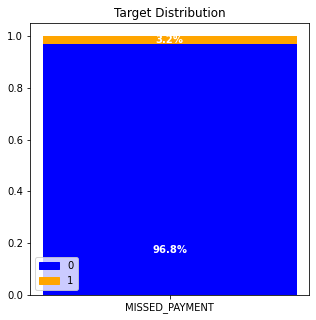

In [7]:
# start by having a look at the target variable
# plot the distribution of the target for each product
df_temp = df_prep[target_col].value_counts().reset_index()
df_temp['perc'] = df_temp[target_col] / df_temp[target_col].sum()

target_0 = df_temp[df_temp['index']==0]['perc'].values[0]
target_1 = df_temp[df_temp['index']==1]['perc'].values[0]

fig1, ax1 = plt.subplots(figsize=(5,5))

ax1.bar(target_col, target_0, label=target_0, color='blue')
ax1.bar(target_col, target_1, bottom=target_0, color='orange')

red_patch = mpatches.Patch(color='orange', label='1')
blue_patch = mpatches.Patch(color='blue', label='0')

plt.legend(handles=[blue_patch, red_patch], loc='best')

plt.title('Target Distribution')

for patch in ax1.patches:
    percentage = '{:.1f}%'.format(100 * patch.get_height())
    x = patch.get_x() + patch.get_width()/2
    y = patch.get_y() + patch.get_height()/6
    ax1.annotate(percentage, (x, y), ha='center', color='white', weight='bold', fontsize=10)

#### Customers with missed payments

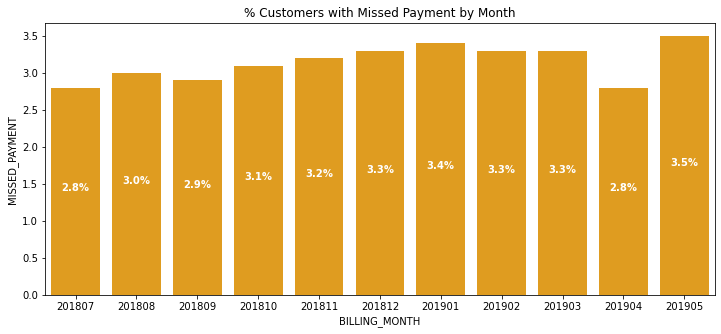

In [8]:
df_prep['BILLING_MONTH'] = df_prep[billing_date_col].astype(str).str[0:6]
df_temp = df_prep.copy()
df_temp = df_temp.dropna(axis=0, subset=[target_col])

df_temp = df_temp.groupby('BILLING_MONTH')[target_col].mean().reset_index()

df_temp[target_col] = np.round(df_temp[target_col] * 100, 1)

fig, ax1 = plt.subplots(figsize=(12, 5))

target_density_plot = sns.barplot(x='BILLING_MONTH', y=target_col, data=df_temp, color="orange", ax=ax1)

target_density_plot = ax1.set_title('% Customers with Missed Payment by Month')

for patch in ax1.patches:
    percentage = '{:.1f}%'.format(patch.get_height())
    x = patch.get_x() + patch.get_width()/2
    y = patch.get_y() + patch.get_height()/2
    ax1.annotate(percentage, (x, y), ha='center', color='white', weight='bold', fontsize=10)

## Prepare the Data

A number of steps are carried out to complete the data preparation stage. 

We first call the function to create some new features. These features are based on the ratio of the current billing cycle value vs previous billing cycle and vs the average of the historical lookback window. We append these new variable names to the list with numerical variables so that they will be included in the transformer later in the code. 

In [9]:
for col in l_cols_to_summarise:
    df_prep = cur_month_vs_historical_summary(df_prep, col, customer_id_col, lookback_window)
    # add the columns that will be created to the list
    l_numerical_features.append('RATIO_THIS_MONTH_' + col + '_VS_LAST_MONTH')  
    l_numerical_features.append('RATIO_THIS_MONTH_' + col + '_VS_AVG_LOOKBACK_WINDOW')  

Next we create a variable which is a count of the number of times the customer has missed a payment in the historical lookback window period. 

In [10]:
# how many times as a cusotmer missed a payment in the lookback period?
df_prep['NUM_MISSED_PAYMENTS_LOOKBACK_WINDOW'] = df_prep.groupby(customer_id_col)[target_col].shift(1).rolling(lookback_window).sum()

l_numerical_features.append('NUM_MISSED_PAYMENTS_LOOKBACK_WINDOW')

Since we are building the models over approximately 11-12 billing cycles, we create a variable to account for any seasonality impacts. We include a categorical variable for the billing month number.  

In [11]:
df_prep['BILLING_MONTH_NUMBER'] = df_prep[billing_date_col].astype(str).str[4:6]
l_categorical_for_dummy_vars.append('BILLING_MONTH_NUMBER')

In [12]:
df_prep.head()

,CUSTOMER_ID,BILLING_DATE,OVERDUE_BALANCE,DUE_DATE,BASE_USAGE,ALTERNATE_USAGE,STANDING_CHARGE,BASE_CHARGE,ALTERNATE_CHARGE,LEVY,...,MISSED_PAYMENT,BILLING_MONTH,RATIO_THIS_MONTH_BASE_USAGE_VS_LAST_MONTH,RATIO_THIS_MONTH_BASE_USAGE_VS_AVG_LOOKBACK_WINDOW,RATIO_THIS_MONTH_ALTERNATE_USAGE_VS_LAST_MONTH,RATIO_THIS_MONTH_ALTERNATE_USAGE_VS_AVG_LOOKBACK_WINDOW,RATIO_THIS_MONTH_TOTAL_TO_PAY_VS_LAST_MONTH,RATIO_THIS_MONTH_TOTAL_TO_PAY_VS_AVG_LOOKBACK_WINDOW,NUM_MISSED_PAYMENTS_LOOKBACK_WINDOW,BILLING_MONTH_NUMBER
10564,1,20180704,0.0,20180719,23.27,18.31,8.95,3.43,1.65,0.42,...,0.0,201807,NaN,NaN,NaN,NaN,NaN,NaN,NaN,07
10565,1,20180802,0.0,20180817,219.70,161.90,8.95,32.38,14.60,1.68,...,0.0,201808,9.441341,NaN,8.842163,NaN,3.985541,NaN,NaN,08
10566,1,20180902,0.0,20180917,233.16,171.58,8.95,34.37,15.48,1.76,...,0.0,201809,1.061265,NaN,1.059790,NaN,1.051081,NaN,NaN,09
10567,1,20181003,0.0,20181018,233.16,178.17,8.95,34.37,16.07,1.78,...,0.0,201810,1.000000,1.469095,1.038408,1.519401,1.010079,1.383597,0.0,10
10568,1,20181102,0.0,20181117,231.64,167.84,8.95,34.14,15.14,1.75,...,0.0,201811,0.993481,1.012973,0.942022,0.984110,0.980590,1.003357,0.0,11


### Split Data and Build Transformer


We split the data into training, validation and test sets. We use 60% of the data for training, 20% for validation and the remaining 20% for testing. We first remove records with missing values for the target variable. These are the latest billing cycle for each customer, as we don't know if the customer will make the payment or not. 

We build the models on the training set, carry out hyperparameter tuning on the validation set and finally apply the selected final model to the unseen test set.  

We use built-in sklearn transformers to process the data and get it ready for input into the model. 

For categorical variables we create a pipeline with 2 steps. We first use the `SimpleImputer` transformer to fill in missing values with 'Other'. Next we use `OneHotEncoder` to create dummy variables for each category. The transformers are applied to the features specified in the `l_categorical_for_dummy_vars` variable.

For numerical variables the pipeline has a single step in our example. We again use the `SimpleImputer` transformer to fill in missing values. The transformer is applied to the features specified in `l_numerical_features`variable.  

The transformers are combined, we fit using the training data and transform the training, validation and test data. The transformer is saved out as a joblib object. It can be imported and used again when preparing new data for scoring. The feature names of the combined transformers are retrieved and stored in a list `numeric_features_list`. This list is used for labelling the feature importance of the final model.

In [13]:
X = df_prep.dropna(axis=0, subset=[target_col]).drop([target_col], axis=1)
y = df_prep.dropna(axis=0, subset=[target_col])[target_col]

X_train, X_val_test, y_train, y_val_test = train_test_split(X, y, stratify=y, test_size=0.40, random_state=123)
X_validation, X_test, y_validation, y_test = train_test_split(X_val_test, y_val_test, stratify=y_val_test, test_size=0.50, random_state=123)

In [14]:
categorical_transformer = Pipeline(steps=[('impute_missing', SimpleImputer(strategy='constant', fill_value='Other')), ('dummy_vars', OneHotEncoder(handle_unknown='ignore'))])
# fill in missing data - we use median to keep the 1, 0  'flag' like variables either 1 or 0
numeric_transformer = Pipeline(steps=[('impute_missing', SimpleImputer(strategy='median'))])

In [15]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, l_numerical_features),
        ('cat', categorical_transformer, l_categorical_for_dummy_vars)
            ])

In [16]:
fitted_preprocessor = preprocessor.fit(X_train)

X_train_postprocess = fitted_preprocessor.transform(X_train)
X_validation_postprocess = preprocessor.transform(X_validation)
X_test_postprocess = preprocessor.transform(X_test)

In [17]:
onehot_columns=list(fitted_preprocessor.named_transformers_['cat'].named_steps['dummy_vars'].get_feature_names(input_features=l_categorical_for_dummy_vars))
numeric_features_list = list(l_numerical_features)
numeric_features_list.extend(onehot_columns)

In [18]:
# Save out the transformer
# mimetype is guessed when promoting the asset into the deployment space
# we need to save the file as a type recognised by the mimetype library
# this doesn't impact the object type
joblib.dump(fitted_preprocessor, '/project_data/data_asset/preprocessor_transformer.txt')

['/project_data/data_asset/preprocessor_transformer.txt']

### Handle Imbalanced Data

As already described, the data is imbalanced, with only **3.2%** of cases having a missed payment. In the cell below we apply an over-sampling technique, **SMOTE**, to address this imbalance. The algorithm creates synthetic data similar to the minority class, in our case, missed payment, and balances the dataset.   

We apply SMOTE to the training data only. We maintain the original distribution of the target in the validation and test data. 

In [19]:
print("Before Applying SMOTE to Training Data: ")

# record the target density before balancing
pre_balancing_target_density = y_train.mean()

df_temp = pd.DataFrame(pd.Series(y_train).value_counts().reset_index())
df_temp.columns=['Target', 'Num Cases']
df_temp.sort_values('Target')

Before Applying SMOTE to Training Data: 


,Target,Num Cases
0,0.0,6362
1,1.0,207


In [20]:
sm = SMOTE(random_state=0)

X_train_postprocess, y_train = sm.fit_sample(X_train_postprocess, y_train)

# record the target density after balancing
post_balancing_target_density = y_train.mean()

In [21]:
print("After Applying SMOTE to Training Data: ")

df_temp = pd.DataFrame(pd.Series(y_train).value_counts().reset_index())
df_temp.columns=['Target', 'Num Cases']
df_temp.sort_values('Target')

After Applying SMOTE to Training Data: 


,Target,Num Cases
1,0.0,6362
0,1.0,6362


## Build Machine Learning Models

### Model Hyperparameter Tuning and Model Selection

We selected a random forest model for this example and do some hyperparameter tuning. We train the models on the newly balanced data before applying them to the imbalanced validation data. The hyperparameter selection which performs best on the imbalanced validation data is selected as final. We use AUC as the evaluation metric.

In [22]:
l_ne = [10, 50]
l_md = [5, 7, 10] 
l_mf = [0.75, 0.9]

highest_validation_auc = 0.0
top_ne = 0
top_md = 0
top_mf = 0.0

for ne in l_ne:
    for md in l_md:
        for mf in l_mf:
            clf = RandomForestClassifier(n_estimators=ne, max_depth=md, max_features=mf, random_state=0)
            clf.fit(X_train_postprocess, y_train)
            
            y_pred_train = clf.predict_proba(X_train_postprocess)[:,1]
            y_pred_validation = clf.predict_proba(X_validation_postprocess)[:,1]
            
            fpr_validation, tpr_validation, thresholds_validation = metrics.roc_curve(y_validation, y_pred_validation)
            fpr_train, tpr_train, thresholds_train = metrics.roc_curve(y_train, y_pred_train)

            auc_validation = metrics.auc(fpr_validation, tpr_validation)
            auc_train = metrics.auc(fpr_train, tpr_train)
            
            if auc_validation > highest_validation_auc:
                print('Training AUC : ' + str(np.round(auc_train, 3)) + ', Validation AUC :' + str(np.round(auc_validation, 3)) + ' from ' + str(ne) + ' estimators, ' + str(md) + ' max depth and ' + str(mf) + ' max features***')
                top_ne = ne
                top_md = md
                top_mf = mf
                highest_validation_auc = auc_validation
            else:
                print('Training AUC : ' + str(np.round(auc_train, 3)) + ', Validation AUC :' + str(np.round(auc_validation, 3)) + ' from ' + str(ne) + ' estimators, ' + str(md) + ' max depth and ' + str(mf) + ' max features')

Training AUC : 0.997, Validation AUC :0.926 from 10 estimators, 5 max depth and 0.75 max features***
Training AUC : 0.996, Validation AUC :0.926 from 10 estimators, 5 max depth and 0.9 max features***
Training AUC : 0.999, Validation AUC :0.921 from 10 estimators, 7 max depth and 0.75 max features
Training AUC : 0.999, Validation AUC :0.922 from 10 estimators, 7 max depth and 0.9 max features
Training AUC : 1.0, Validation AUC :0.895 from 10 estimators, 10 max depth and 0.75 max features
Training AUC : 1.0, Validation AUC :0.891 from 10 estimators, 10 max depth and 0.9 max features
Training AUC : 0.998, Validation AUC :0.922 from 50 estimators, 5 max depth and 0.75 max features
Training AUC : 0.998, Validation AUC :0.92 from 50 estimators, 5 max depth and 0.9 max features
Training AUC : 1.0, Validation AUC :0.917 from 50 estimators, 7 max depth and 0.75 max features
Training AUC : 1.0, Validation AUC :0.916 from 50 estimators, 7 max depth and 0.9 max features
Training AUC : 1.0, Valida

### Build Final Model 

After finding the best performing hyperparameter combination, we apply them to our final model. Again, we build the model on the balanced training data and apply it to the imbalanced validation data. We also apply the model to the, as of yet unseen, test data.

In [23]:
clf = RandomForestClassifier(n_estimators=top_ne, max_depth=top_md, max_features=top_mf, random_state=0)

clf.fit(X_train_postprocess, y_train)

y_pred_train = clf.predict_proba(X_train_postprocess)[:,1]
y_pred_validation = clf.predict_proba(X_validation_postprocess)[:,1]
y_pred_test = clf.predict_proba(X_test_postprocess)[:,1]

fpr_train, tpr_train, thresholds_train = metrics.roc_curve(y_train, y_pred_train)
fpr_validation, tpr_validation, thresholds_validation = metrics.roc_curve(y_validation, y_pred_validation)
fpr_test, tpr_test, thresholds_test = metrics.roc_curve(y_test, y_pred_test)

auc_train = metrics.auc(fpr_train, tpr_train)
auc_validation = metrics.auc(fpr_validation, tpr_validation)
auc_test = metrics.auc(fpr_test, tpr_test)

print('Training AUC : ' + str(np.round(auc_train, 3)) + ', Validation AUC :' + str(np.round(auc_validation, 3)) + ' and Test AUC :' + str(np.round(auc_test, 3)) + ' from ' + str(top_ne) + ' estimators, ' + str(top_md) + ' max depth and ' + str(top_mf) + ' max features')

Training AUC : 0.996, Validation AUC :0.926 and Test AUC :0.951 from 10 estimators, 5 max depth and 0.9 max features


All customers are assigned a probability of missing their bill payment. If the user would also like to assign a 1, 0 classification to each customer we need to make an adjustment to the probabilities. This is because the class distribution of the balanced training data that the model was built on is not the same as the imbalanced class distribution of the validation and test sets. More information on this can be found by searching for the following topic: `rescale model probabilities after oversampling`. This adjustment to the probabilities does not impact the probability ranking so if the user is interested in only ranking customers based on model results, this adjustment isn't required. The adjustment also does not change the AUC so the model evaluation above is still valid. We recreate the data for the ROC Curve as probability thresholds will change.

In [24]:
# make adjustment to probabilities
y_pred_validation = 1/(1+(1/pre_balancing_target_density-1)/(1/post_balancing_target_density-1)*(1/y_pred_validation-1))
y_pred_test = 1/(1+(1/pre_balancing_target_density-1)/(1/post_balancing_target_density-1)*(1/y_pred_test-1))

In [25]:
# recreate the data for ROC Curve and confirm that the AUC is the same
fpr_validation, tpr_validation, thresholds_validation = metrics.roc_curve(y_validation, y_pred_validation)
fpr_test, tpr_test, thresholds_test = metrics.roc_curve(y_test, y_pred_test)

auc_validation = metrics.auc(fpr_validation, tpr_validation)
auc_test = metrics.auc(fpr_test, tpr_test)

print('Validation AUC :' + str(np.round(auc_validation, 3)) + ' and Test AUC :' + str(np.round(auc_test, 3)) + ' from ' + str(top_ne) + ' estimators, ' + str(top_md) + ' max depth and ' + str(top_mf) + ' max features')

Validation AUC :0.926 and Test AUC :0.951 from 10 estimators, 5 max depth and 0.9 max features


### View Model Results

First we'll look at the plot of the ROC curve since we used area under the ROC curve (AUC) as the model evaluation metric. The ROC curve is a plot of the true positive rate `(Sensitivity)` and false positive rate `(1-Specificity)`. Each point on the ROC curve represents a sensitivity/specificity pair corresponding to a particular decision threshold.

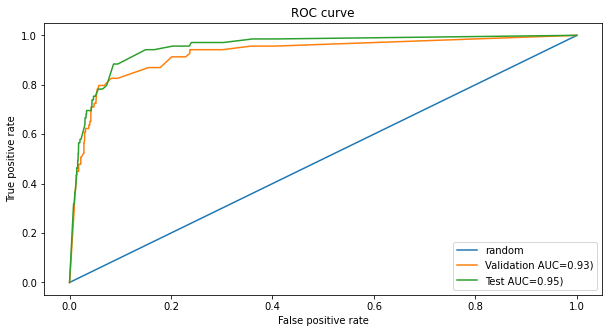

In [26]:
fig = plt.figure(figsize=(10,5))
plt.plot([0, 1], [0, 1], label='random')

plt.plot(fpr_validation, tpr_validation, label= 'Validation AUC=' + str(np.round(auc_validation, 2)) + ')')
plt.plot(fpr_test, tpr_test, label= 'Test AUC=' + str(np.round(auc_test, 2)) + ')')

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')

plt.show()

If the user would also like to assign a 1, 0 classification to each customer we can use the result from the ROC curve. Based on the validation ROC curve result we select the optimum threshold value based on Youden's Index. Any probabilities greater than the selected threshold will be classed as 1, otherwise 0. 

In [27]:
# get the optimal threshold based on Youden's index
idx_opt_thres = np.argmax(tpr_validation - fpr_validation)
opt_threshold = thresholds_validation[idx_opt_thres]
print(opt_threshold)
y_pred_class_validation = y_pred_validation >= opt_threshold
y_pred_class_validation = y_pred_class_validation.astype(int)
y_pred_class_test = y_pred_test >= opt_threshold
y_pred_class_test = y_pred_class_test.astype(int)

0.002542106962715702


In [28]:
# Alternatively the analyst can select a false positive rate they are happy with and find the threshold from that
# This can be changed to a specified true positive rate with small changes to the code
#fpr_threshold = 0.05
#idx_selected_fpr = np.argmin(fpr_test < fpr_threshold)
#opt_threshold = thresholds_test[idx_selected_fpr]

#y_pred_class_validation = y_pred_validation >= opt_threshold
#y_pred_class_validation = y_pred_class_validation.astype(int)
#y_pred_class_test = y_pred_test >= opt_threshold
#y_pred_class_test = y_pred_class_test.astype(int)

We'll next look at the confusion matrices for the validation and test results at the threshold selected above. At this threshold the classifier does a good job at correctly predicting those who miss a payment or not. However, it also misclassifies quite a few customers as missing a payment when they have not actually missed it (False Positives). Depending on the business decision to be made from the model, this result may not be sufficient. For example, a reminder call to customers falsely predicted to miss the payment may be seen as intrusive or costly. Based on this, the analyst may want to change the threshold by reducing the false positive rate (as commented out above). Doing this does result in a trade off and the number of true positives (predicted to miss the payment and actually missed it) would reduce. 

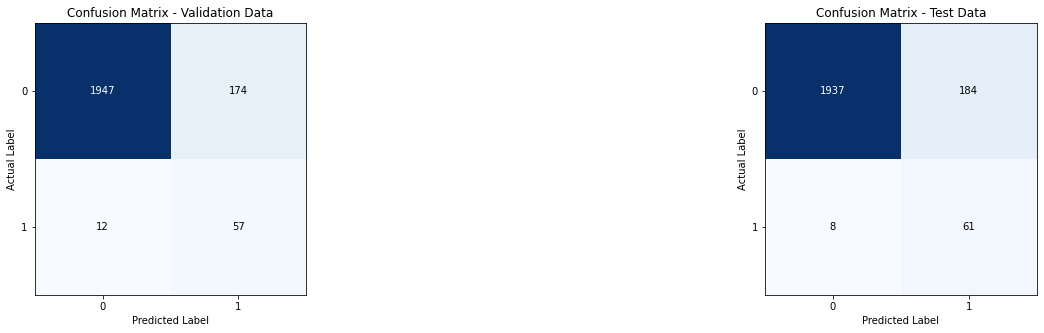

In [29]:
confusion_matrix_validation = metrics.confusion_matrix(y_validation, y_pred_class_validation, labels=[0,1])
confusion_matrix_test = metrics.confusion_matrix(y_test, y_pred_class_test, labels=[0,1])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 5))

ax1.imshow(confusion_matrix_validation, interpolation='nearest', cmap=plt.cm.Blues)
ax1.set_title('Confusion Matrix - Validation Data')
tick_marks = np.arange(2)
ax1.set_xticks(tick_marks)
ax1.set_yticks(tick_marks)
ax1.set_ylabel('Actual Label')
ax1.set_xlabel('Predicted Label')
# iterate through the confusion matrix array with indexing, use this to plot counts on the chart
cm_iterator = np.nditer(confusion_matrix_validation, flags=['multi_index'])
while not cm_iterator.finished:
    num_occurances = cm_iterator[0]
    y = cm_iterator.multi_index[0]
    x = cm_iterator.multi_index[1]
    ax1.text(x, y, num_occurances, color="white" if confusion_matrix_validation[x, y] > confusion_matrix_validation.max()/2 else "black", ha='center', va='center')
    cm_iterator.iternext()

ax2.imshow(confusion_matrix_test, interpolation='nearest', cmap=plt.cm.Blues)
ax2.set_title('Confusion Matrix - Test Data')
ax2.set_xticks(tick_marks)
ax2.set_yticks(tick_marks)
ax2.set_ylabel('Actual Label')
ax2.set_xlabel('Predicted Label')
# iterate through the confusion matrix array with indexing, use this to plot counts on the chart
cm_iterator = np.nditer(confusion_matrix_test, flags=['multi_index'])
while not cm_iterator.finished:
    num_occurances = cm_iterator[0]
    y = cm_iterator.multi_index[0]
    x = cm_iterator.multi_index[1]
    ax2.text(x, y, num_occurances, color="white" if confusion_matrix_test[x, y] > confusion_matrix_test.max()/2 else "black", ha='center', va='center')
    cm_iterator.iternext()

Next we will group the probabilities up into Low, Medium and High Risk. First we plot the distribution of the probabilities along with the assigned class for the validation data. We select the categories based on these probabilities and class labels. The data scientist can update these values based on their own business knowledge or model results.

For our case we use:
* Low risk is anybody that is classed as 0
* Medium is anyone with class 1 and probability < 70%
* High is anyone with > 70%  probability of missing the payment

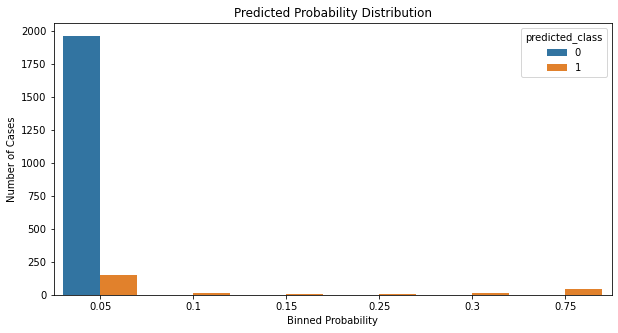

In [30]:
df_probs = pd.DataFrame({'predicted_probability' : y_pred_validation, 'predicted_class' : y_pred_class_validation})
df_probs['binned_prob'] = np.ceil(df_probs['predicted_probability'] * 20) / 20

df_probs = df_probs.groupby(['binned_prob', 'predicted_class']).count().reset_index()
df_probs.rename(columns={'predicted_probability' : 'num_cases'}, inplace=True)

fig1, ax1 = plt.subplots(figsize=(10,5))

sns.barplot(x="binned_prob", y="num_cases", hue="predicted_class", data=df_probs)
plt.xlabel('Binned Probability')
plt.ylabel('Number of Cases')
plt.title('Predicted Probability Distribution')
plt.show()

## Feature Importance of the model

With tree based models we can view variable importance plots. These plots indicate, at the feature level, some importance for the variable in classifying the outcome variable. It uses gini importance (mean decrease in impurity) which looks at node impurity. Node impurity is just looking at how well a tree splits the data. Technically it calculates each feature importance as the sum over the number of splits that include the feature, proportionally to the number of samples it splits.

We'll take a look at the feature importance plots for the random forest models. 

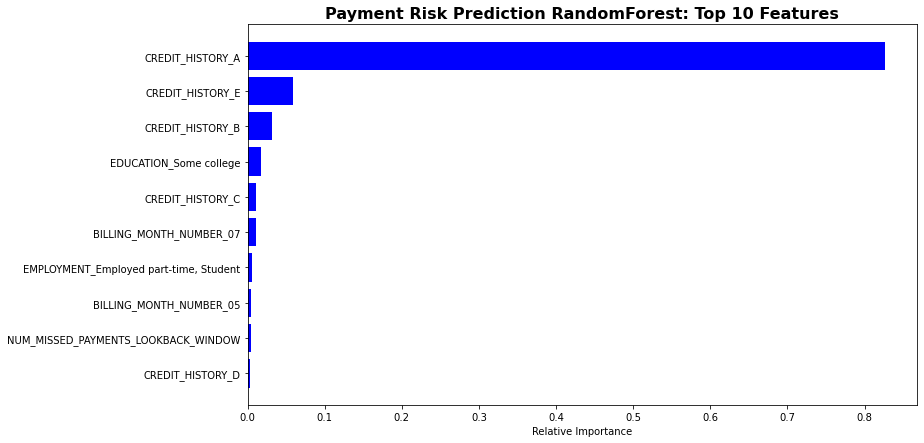

In [31]:
plot_feature_importance(feature_list=numeric_features_list, 
                        feature_importances=clf.feature_importances_, 
                        title="Payment Risk Prediction RandomForest: Top 10 Features")

### Save Data for RShiny Dashboard

We save the data out for use in the RShiny dashboard. We score the `df_prep` dataframe and save the dataframe and scores out. This data contains records for all customers and all billing cycles, including the latest cycle for each customer, where the actual target value is not known.

In [32]:
X_total_postprocess = fitted_preprocessor.transform(df_prep.drop([target_col], axis=1))
y_pred_total = clf.predict_proba(X_total_postprocess)[:,1]
# make the same adjustment as we previously carried out
y_pred_total =  1/(1+(1/pre_balancing_target_density-1)/(1/post_balancing_target_density-1)*(1/y_pred_total-1))

y_pred_class_total = y_pred_total >= opt_threshold
y_pred_class_total = y_pred_class_total.astype(int)

df_prep.rename(columns={target_col : 'actual'}, inplace=True)
df_prep['predicted_probability'] = y_pred_total
df_prep['predicted_class'] = y_pred_class_total

df_prep['payment_risk'] = 'Low'
df_prep.loc[(df_prep['predicted_class']==1)& (df_prep['predicted_probability']< 0.7), 'payment_risk'] = 'Medium'
df_prep.loc[(df_prep['predicted_class']==1)& (df_prep['predicted_probability']>= 0.7), 'payment_risk'] = 'High'

# update the billing month format
df_prep['BILLING_MONTH'] = pd.to_datetime(df_prep['BILLING_MONTH'], format='%Y%m')
df_prep['BILLING_MONTH'] = df_prep['BILLING_MONTH'].dt.strftime("%b-%Y")

df_prep[l_categorical_for_dummy_vars] = df_prep[l_categorical_for_dummy_vars].fillna('Other')

project.save_data('model output summary.csv', df_prep.to_csv(index=False), overwrite=True)

{'file_name': 'model output summary.csv',
 'message': 'File saved to project storage.',
 'asset_id': '732ce072-1a74-4ba0-878a-970772d7fc9b'}

## Save the Model to Cloud Pak for Data

In the next steps we save and deploy the model.  

Before we save the model we must create a deployment space. Watson Machine Learning provides deployment spaces where the user can save, configure and deploy their models. We can save models, functions and data assets in this space. 

The steps involved in saving and deploying the pipeline are detailed in the following cells. We will use the [ibm-watson-machine-learning](http://ibm-wml-api-pyclient.mybluemix.net) package to complete these steps.



### User Inputs

The user can specify the name for the space, models and model deployments.
If a space with specified space_name already exists, user can either use the existing space by specifying `use_existing_space=True` or delete the existing space and create a new one by specifying `use_existing_space=False` below. By default use_existing_space is set to `True`

In [33]:
# Specify a name for the space being created, the saved model and the model deployment
space_name = 'Utilities Payment Risk Prediction Space'
model_name = 'utilities_payment_risk_prediction_model'
deployment_name = 'utilities_payment_risk_prediction_model_deployment'

use_existing_space=True

In [34]:
from ibm_watson_machine_learning import APIClient
import os

token = os.environ['USER_ACCESS_TOKEN']

wml_credentials = {
   "token": token,
   "instance_id" : "openshift",
   "url": os.environ['RUNTIME_ENV_APSX_URL'],
   "version": "3.5"
}

client = APIClient(wml_credentials)

### Create the Deployment Space
Create a new deployment space using name of the space as specified in the user inputs cell above. The space name will be used in future to identify this space.

By default, if the space with specified name already exists, the existing space will be used to store and deploy the models.

In [35]:
space_uid=""
for space in client.spaces.get_details()['resources']:

    if space['entity']['name'] ==space_name:
        print("Deployment space with ",space_name,"already exists . .")
        space_uid=space['metadata']['id']
        client.set.default_space(space_uid)
        if(use_existing_space==False):

            for deployment in client.deployments.get_details()['resources']:
                print("Deleting deployment",deployment['entity']['name'], "in the space",)
                deployment_id=deployment['metadata']['id']
                client.deployments.delete(deployment_id)
            print("Deleting Space ",space_name,)
            client.spaces.delete(space_uid)
            time.sleep(5)
        else:
            print("Using the existing space")
            
            
if (space_uid=="" or use_existing_space==False):
    print("\nCreating a new deployment space -",space_name)
    # create the space and set it as default
    space_meta_data = {
        client.spaces.ConfigurationMetaNames.NAME : space_name

        }

    stored_space_details = client.spaces.store(space_meta_data)

    space_uid = stored_space_details['metadata']['id']

    client.set.default_space(space_uid)


Creating a new deployment space - Utilities Payment Risk Prediction Space
Space has been created. However some background setup activities might still be on-going. Check for 'status' field in the response. It has to show 'active' before space can be used. If its not 'active', you can monitor the state with a call to spaces.get_details(space_id)


### Store the Model Details
Store the model in the deployment space. The name for the model is specified in the user inputs cell above. Software specification, default tag and input data schema for the model are specified in the model metadata. Example to create a metatadata can be viewed using `client.repository.ModelMetaNames.get_example_values()`.<br>
The Software Specification refers to the runtime used in the Notebook, WML training and WML deployment. We use the software specification `default_py3.7` to store the models. We get the ID of the software specification and include it in the metadata when storing the model. Available Software specifications can be retrieved using `client.software_specifications.list()`.

 

In [36]:
sw_spec_uid = client.software_specifications.get_uid_by_name("default_py3.7")

metadata = {
    client.repository.ModelMetaNames.NAME: model_name,
    client.repository.ModelMetaNames.INPUT_DATA_SCHEMA:[{'id': '1', 'type': 'struct', 'fields': [{"name":column_name,"type":str(column_type[0])} for column_name,column_type in pd.DataFrame(X_train.dtypes).T.to_dict('list').items()]}],
    client.repository.ModelMetaNames.TYPE: "scikit-learn_0.23",
    client.repository.ModelMetaNames.SOFTWARE_SPEC_UID: sw_spec_uid 
}

stored_model_details = client.repository.store_model(model=clf, meta_props=metadata)
stored_model_details

{'entity': {'schemas': {'input': [{'fields': [{'name': 'CUSTOMER_ID',
       'type': 'int64'},
      {'name': 'BILLING_DATE', 'type': 'int64'},
      {'name': 'OVERDUE_BALANCE', 'type': 'float64'},
      {'name': 'DUE_DATE', 'type': 'int64'},
      {'name': 'BASE_USAGE', 'type': 'float64'},
      {'name': 'ALTERNATE_USAGE', 'type': 'float64'},
      {'name': 'STANDING_CHARGE', 'type': 'float64'},
      {'name': 'BASE_CHARGE', 'type': 'float64'},
      {'name': 'ALTERNATE_CHARGE', 'type': 'float64'},
      {'name': 'LEVY', 'type': 'float64'},
      {'name': 'TAX', 'type': 'float64'},
      {'name': 'TOTAL_NET', 'type': 'float64'},
      {'name': 'TOTAL_TO_PAY', 'type': 'float64'},
      {'name': 'FIRST_NAME', 'type': 'object'},
      {'name': 'LAST_NAME', 'type': 'object'},
      {'name': 'PHONE_1', 'type': 'object'},
      {'name': 'EMAIL', 'type': 'object'},
      {'name': 'AGE', 'type': 'int64'},
      {'name': 'IS_REGISTERED_FOR_ALERTS', 'type': 'int64'},
      {'name': 'OWNS_HOME',

### Deploy the Model

Deploy the saved model. The deployment name is specified in the user inputs cell above. Again, a default tag for the deployment is specified in the deployment metadata. 

We also create a dictionary with model metadata here. The dictionary contains another dictionary with the inputs the user specified at the beginning of the notebook. We also store the new probability threshold in the dictionary as well as the pre and post training balancing target densities. We save the dictionary as part of the metadata, in `client.deployments.ConfigurationMetaNames.CUSTOM`, when deploying the pipeline. It gets deployed with the pipeline and can be retrieved in the deployed function, as demonstrated in the **2-Model_Scoring_and_app_deployment** notebook.

In [37]:
metadata_dict = {'user_inputs' : user_inputs_dict, 'probability_threshold' : opt_threshold, 'training_data_pre_balancing_target_density' : pre_balancing_target_density,
                    'training_data_post_balancing_target_density' : post_balancing_target_density}

In [38]:
# create meta-props for the model
meta_props = {
    client.deployments.ConfigurationMetaNames.NAME: deployment_name,
    client.deployments.ConfigurationMetaNames.TAGS : ['utilities_payment_risk_prediction_model_deployment_tag'],
    client.deployments.ConfigurationMetaNames.ONLINE: {},
    client.deployments.ConfigurationMetaNames.CUSTOM: metadata_dict
}

# deploy the model

model_uid = stored_model_details["metadata"]["id"]
deployment_details = client.deployments.create( artifact_uid=model_uid, meta_props=meta_props)



#######################################################################################

Synchronous deployment creation for uid: 'c54106b8-4918-44ca-a725-3eaeba875134' started

#######################################################################################


initializing
ready


------------------------------------------------------------------------------------------------
Successfully finished deployment creation, deployment_uid='a0d06525-b2af-4db0-b449-af4c0057766d'
------------------------------------------------------------------------------------------------




### Operationalize the models
Now we are ready to operationalize our model. See notebook **2-Model_Scoring_and_app_deployment** for the next step.